### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [445]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import acor
import corner
import ultranest
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [536]:
#1 
info = np.load('./hw_data/hw5_data_1.npy') #Loads in from directory
t = info[:,0]
flux = info[:,1]
err = info[:,2]

Text(0.5, 1.0, 'Flux vs Time')

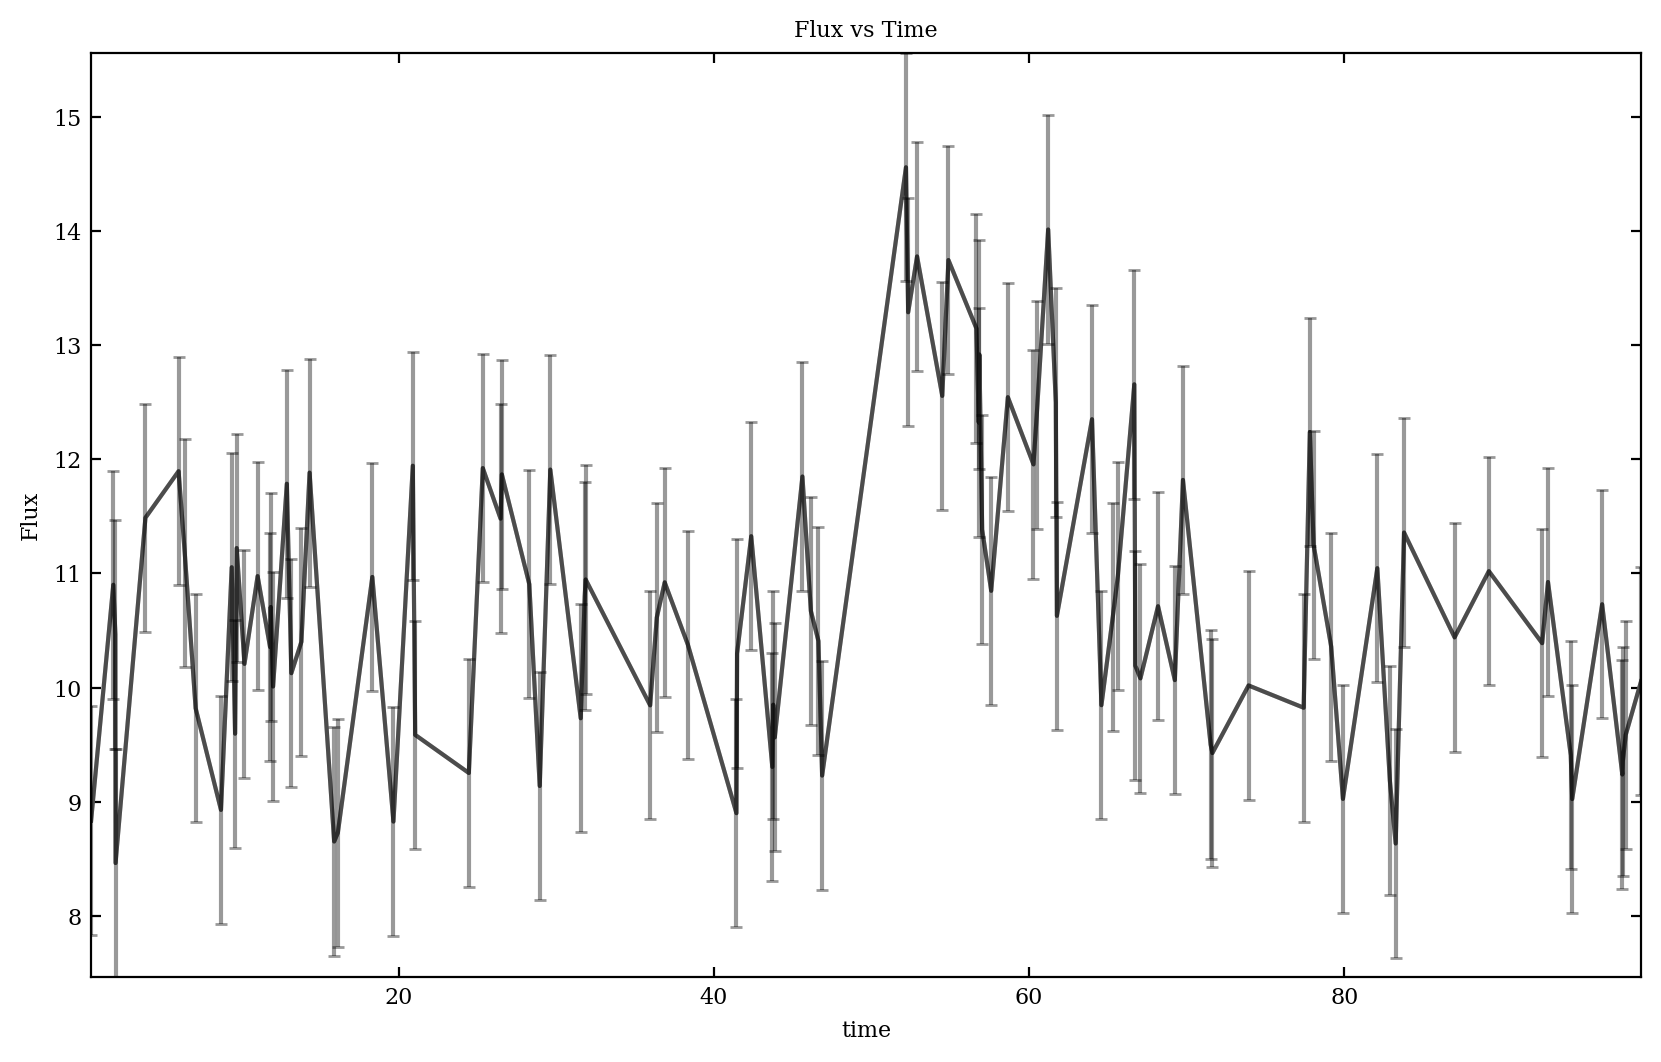

In [537]:
plt.figure(figsize=(10,6)) #Rescale for better presentation 
plt.plot(t,flux, color = "grey")
plt.errorbar(t,flux, yerr=err, capsize = 2, color = "black", alpha  = 0.4)
plt.ylabel('Flux')
plt.xlabel('time')
plt.title('Flux vs Time')

In [544]:
#2 
#Fit Function
def BOOM(x,data):
    mask = info[:,0] >= x[2] #Create the piecewise point
    Piece = np.ones(len(info[:,0]))*x[0] #Initial plot
    Piece[mask] = x[0]+ x[1] * np.exp(-x[3]*(info[mask,0]-x[2])) #Second section
    return Piece

#Log Likelihood
def logL(x, model=BOOM):
    t = info[:,0]
    y = info[:,1]
    sigma_y = info[:,2]
    y_fit = model(x,t)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

In [539]:
#3
#Log Prior
def logUPrior(x):
    a = scipy.stats.uniform.logpdf(x[0], loc = 0, scale = 50)
    b = scipy.stats.uniform.logpdf(x[1], loc = 0, scale = 50)
    c = scipy.stats.uniform.logpdf(x[2], loc = 0, scale = 100)
    d = scipy.stats.uniform.logpdf(np.log(x[3]), loc = -5, scale = 10)
    return a+b+c+d

In [542]:
#3 cont. 
# dimension of parameter space
ndim = 4
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)
# intialize sampler
sampler = ptmcmc(ndim, logL, logUPrior, cov, 
                 outDir='./hw5_direc', resume=False) #direc was added in commit

In [545]:
#3 cont.
N = int(3e5) 
x0 = np.array([7.0, 5.0,5.0,2.0])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent in 0.001415 s Acceptance rate = 0

/var/folders/tc/syqns4sx18gckcc8k7ns3vdw0000gn/T/ipykernel_1188/690874371.py:7: RuntimeWarning: invalid value encountered in log
  d = scipy.stats.uniform.logpdf(np.log(x[3]), loc = -5, scale = 10)
/var/folders/tc/syqns4sx18gckcc8k7ns3vdw0000gn/T/ipykernel_1188/1225153364.py:6: RuntimeWarning: overflow encountered in exp
  Piece[mask] = x[0]+ x[1] * np.exp(-x[3]*(data[mask,0]-x[2])) #Second section
/Users/noah/anaconda3/envs/astr8070/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:365: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC


Finished 3.33 percent in 30.494339 s Acceptance rate = 0.479311Adding DE jump with weight 50
Finished 100.00 percent in 909.742188 s Acceptance rate = 0.387583
Run Complete


In [569]:
#4 Load the Chain
chain = np.loadtxt('./hw5_direc/chain_1.txt')
john = np.arange(4)
for b in john:
    thin = []
    thin.append((acor.acor(chain[:,b])[0])) #Auto correction thin
thin = int(np.max(thin))
print(thin) #Just Checking it

7


Text(0.5, 0, 'Trials')

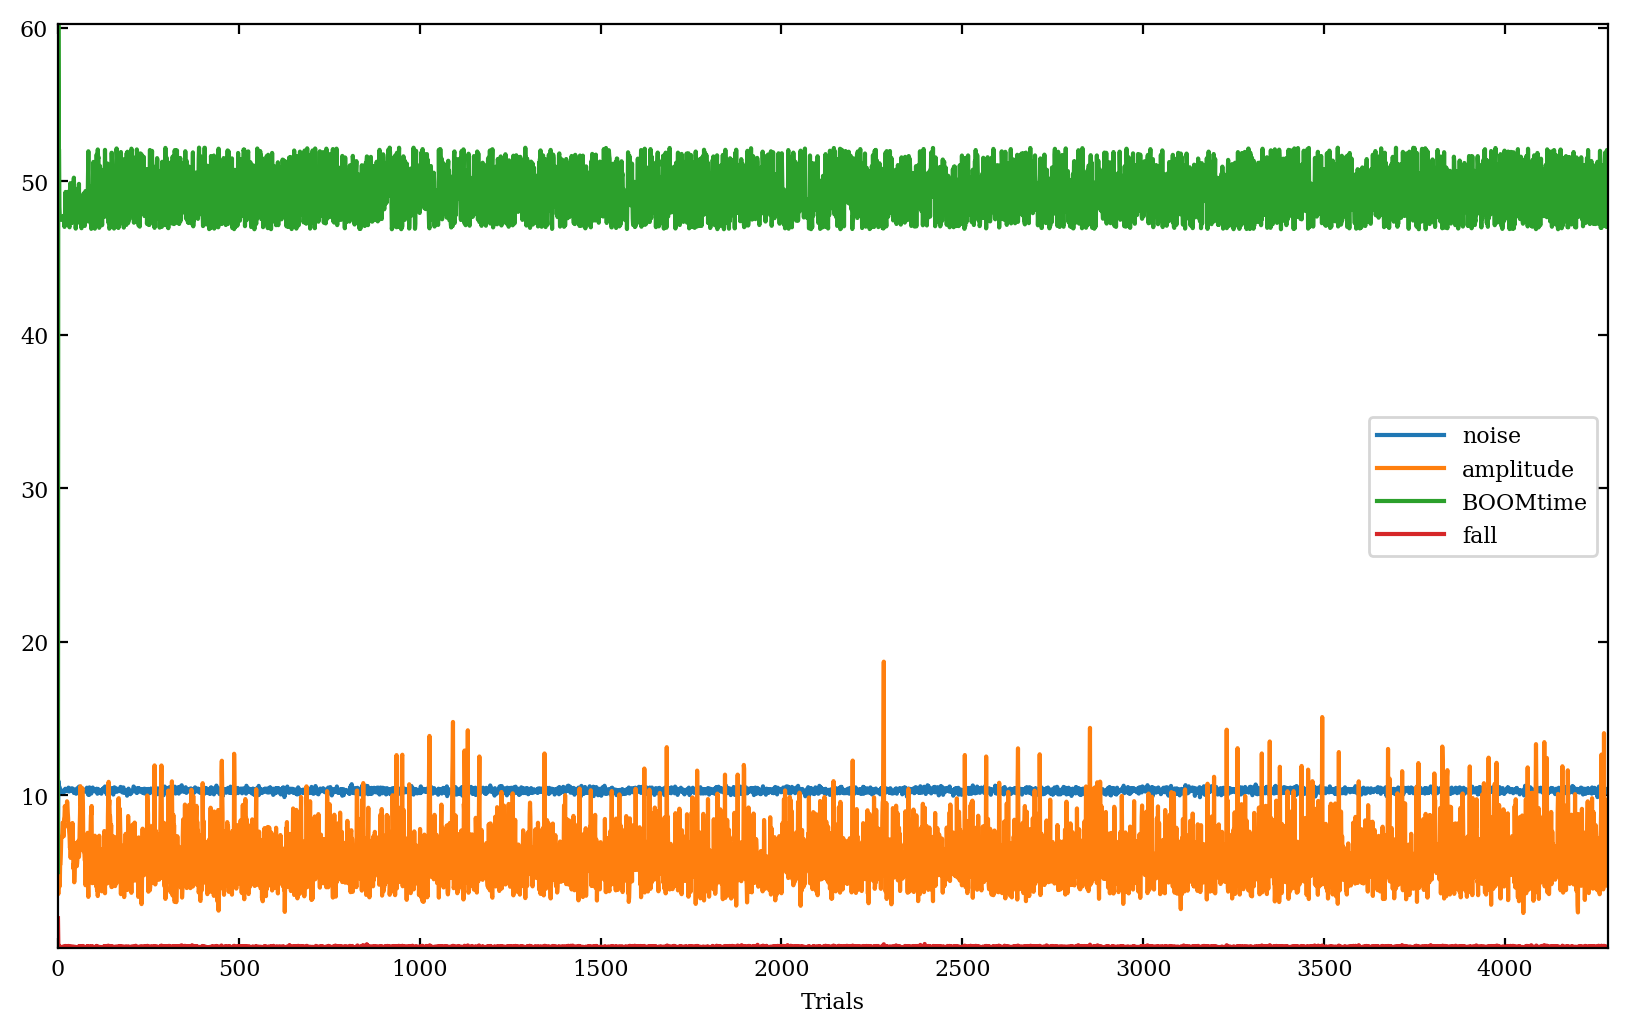

In [570]:
#Plot the thinned data to understand where to burn the data
plt.figure(figsize=(10,6))

#Each Respective Plots, with labels 
plt.plot(chain[::thin,0], label = 'noise')
plt.plot(chain[::thin,1], label = 'amplitude')
plt.plot(chain[::thin,2], label = 'BOOMtime')
plt.plot(chain[::thin,3], label = 'fall')
plt.legend()
plt.xlabel('Trials')

From the above data we can say that ~100 with the thinning (so 700 actually) would be enough for burning

Text(0.5, 0, 'Trials')

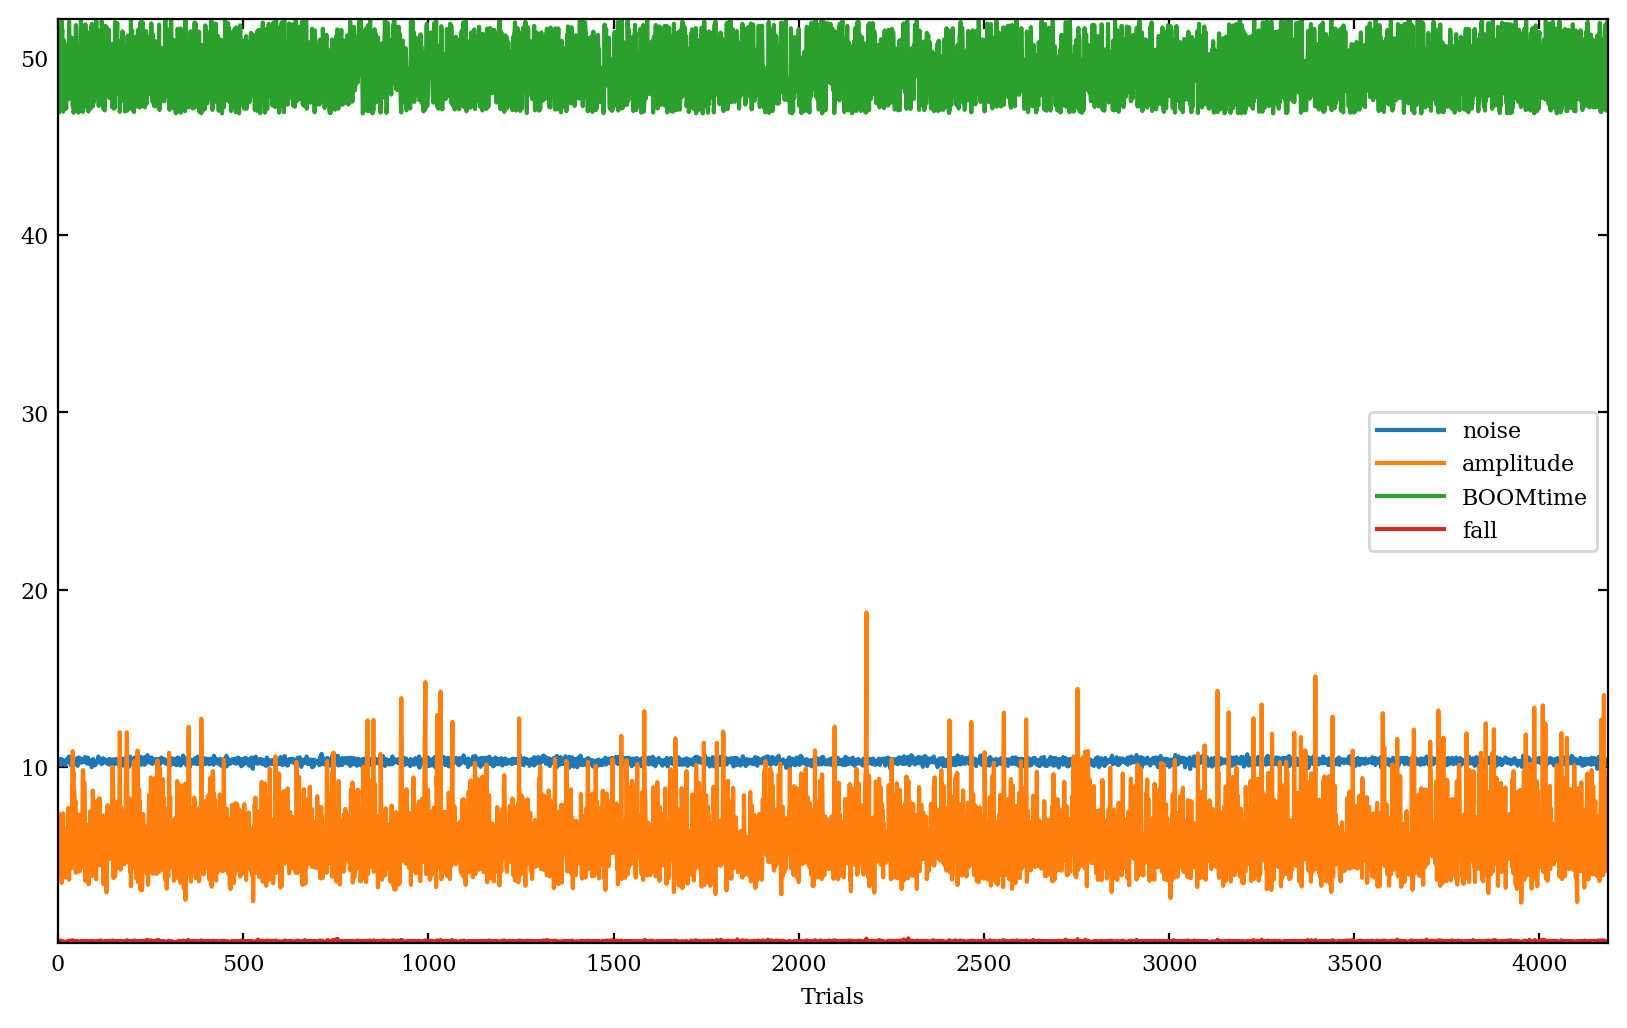

In [572]:
plt.figure(figsize=(10,6))
a = chain[700::thin,0]
b = chain[700::thin,1]
c = chain[700::thin,2]
d = chain[700::thin,3]

plt.plot(a, label = 'noise')
plt.plot(b, label = 'amplitude')
plt.plot(c, label = 'BOOMtime')
plt.plot(d, label = 'fall')
plt.legend()
plt.xlabel('Trials')

In [573]:
#5
comb = np.array([a,b,c,d]) #Create an nested array
comb = np.transpose(comb) #Transpose to fix stuff

In [492]:
!pip3 install ipywidgets

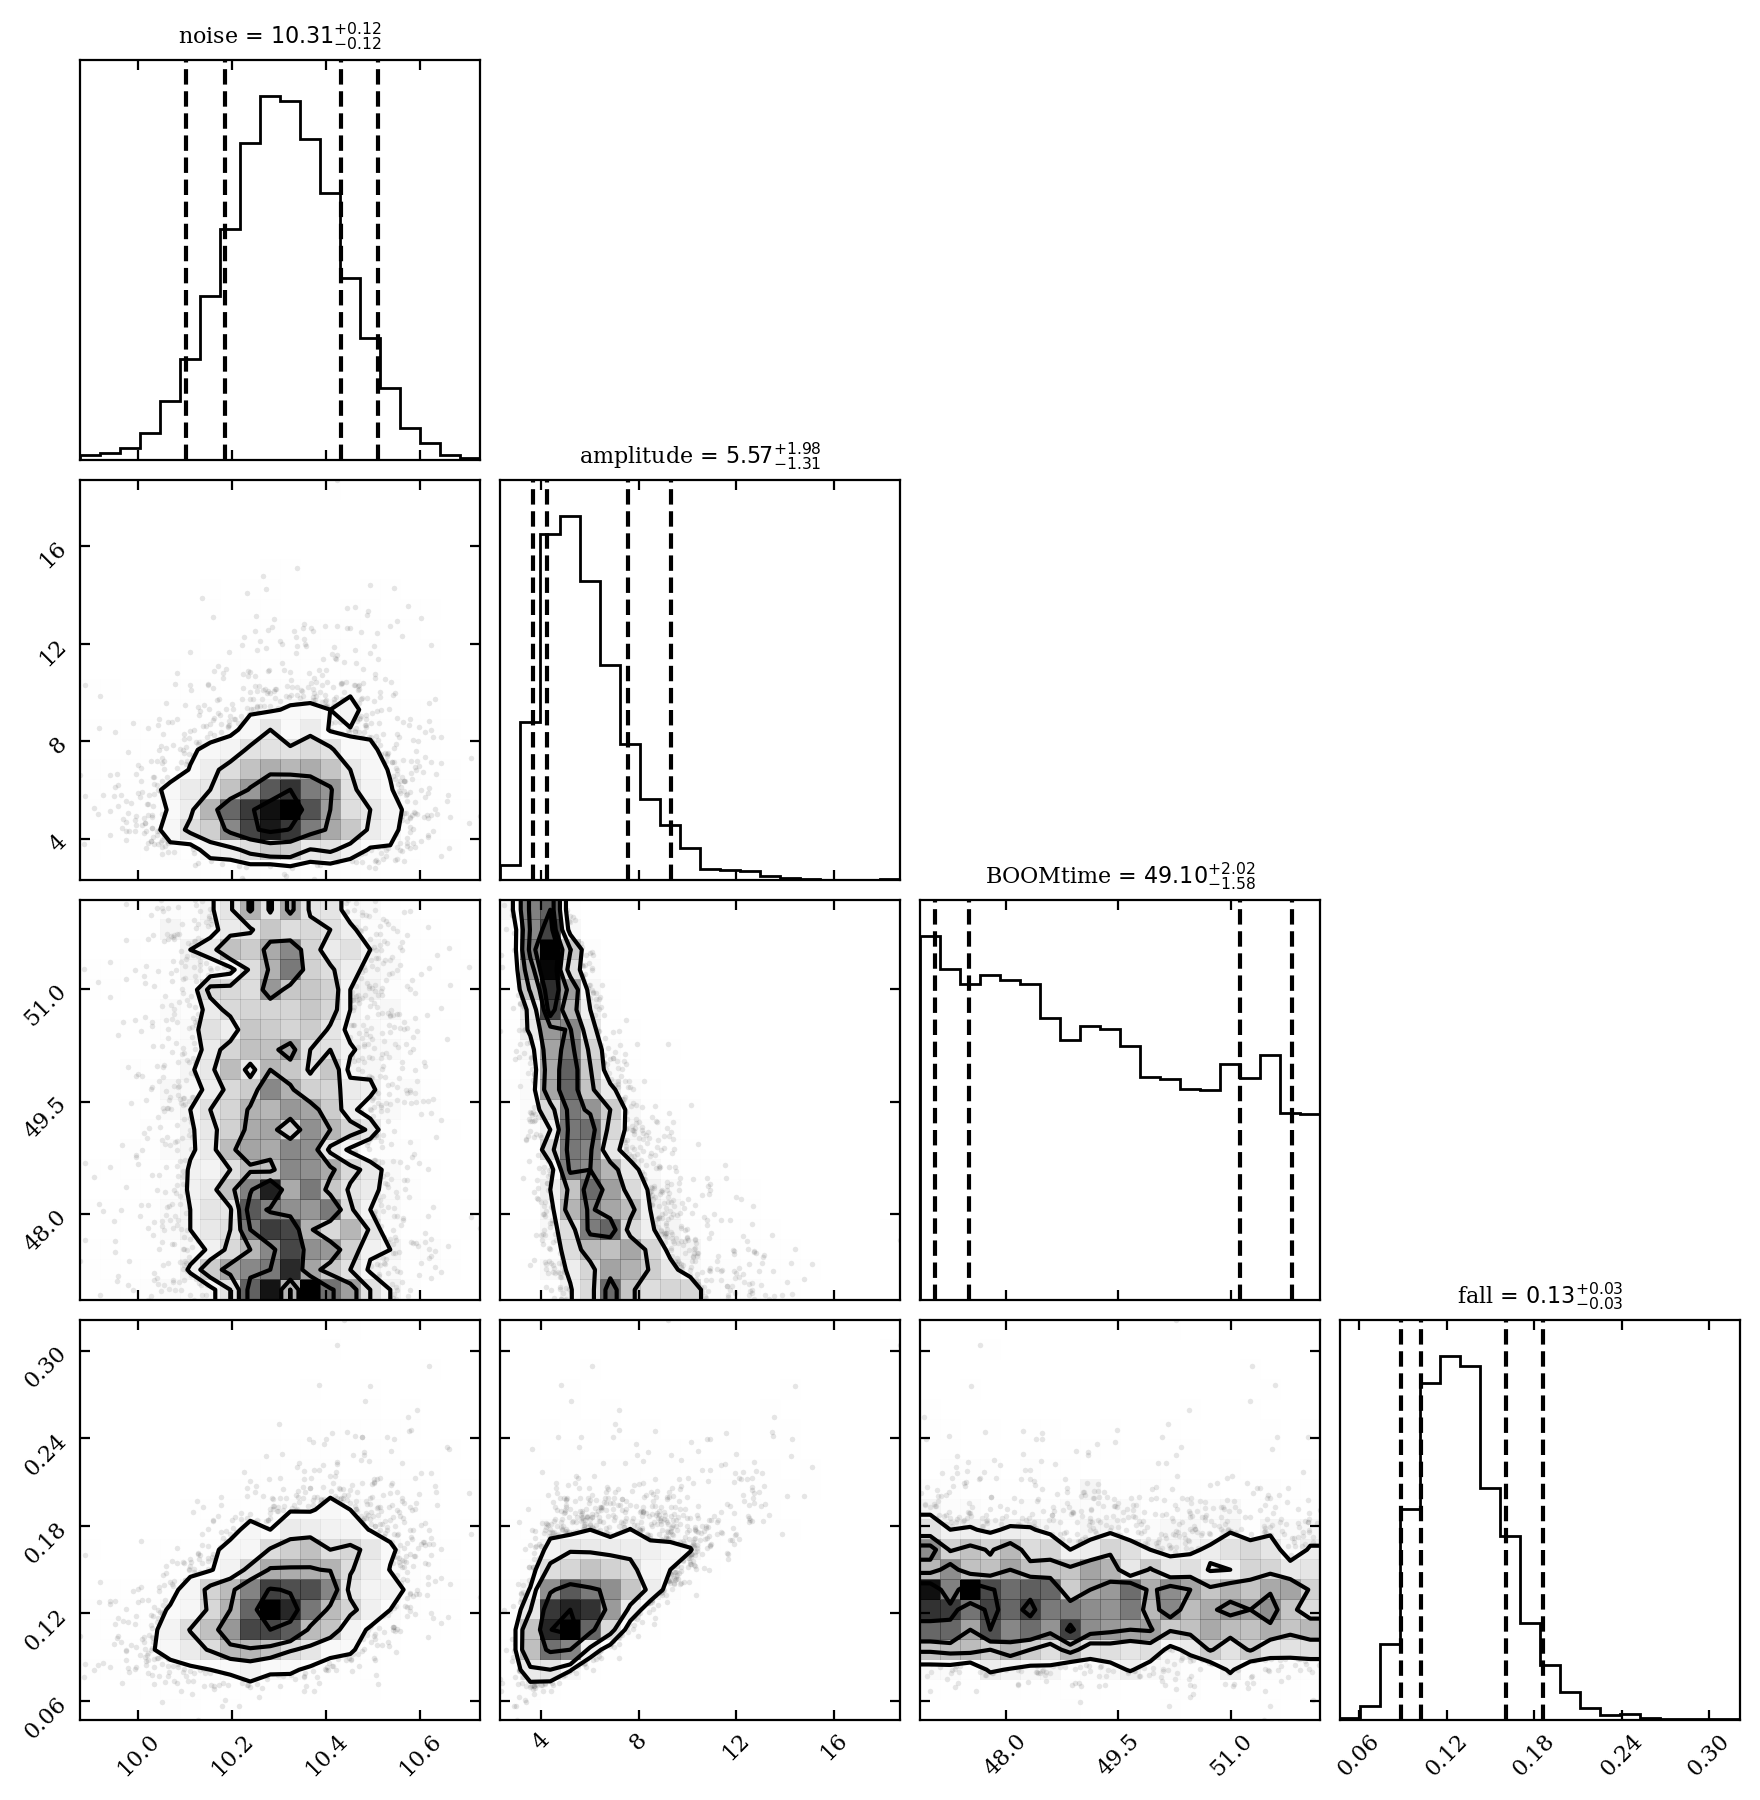

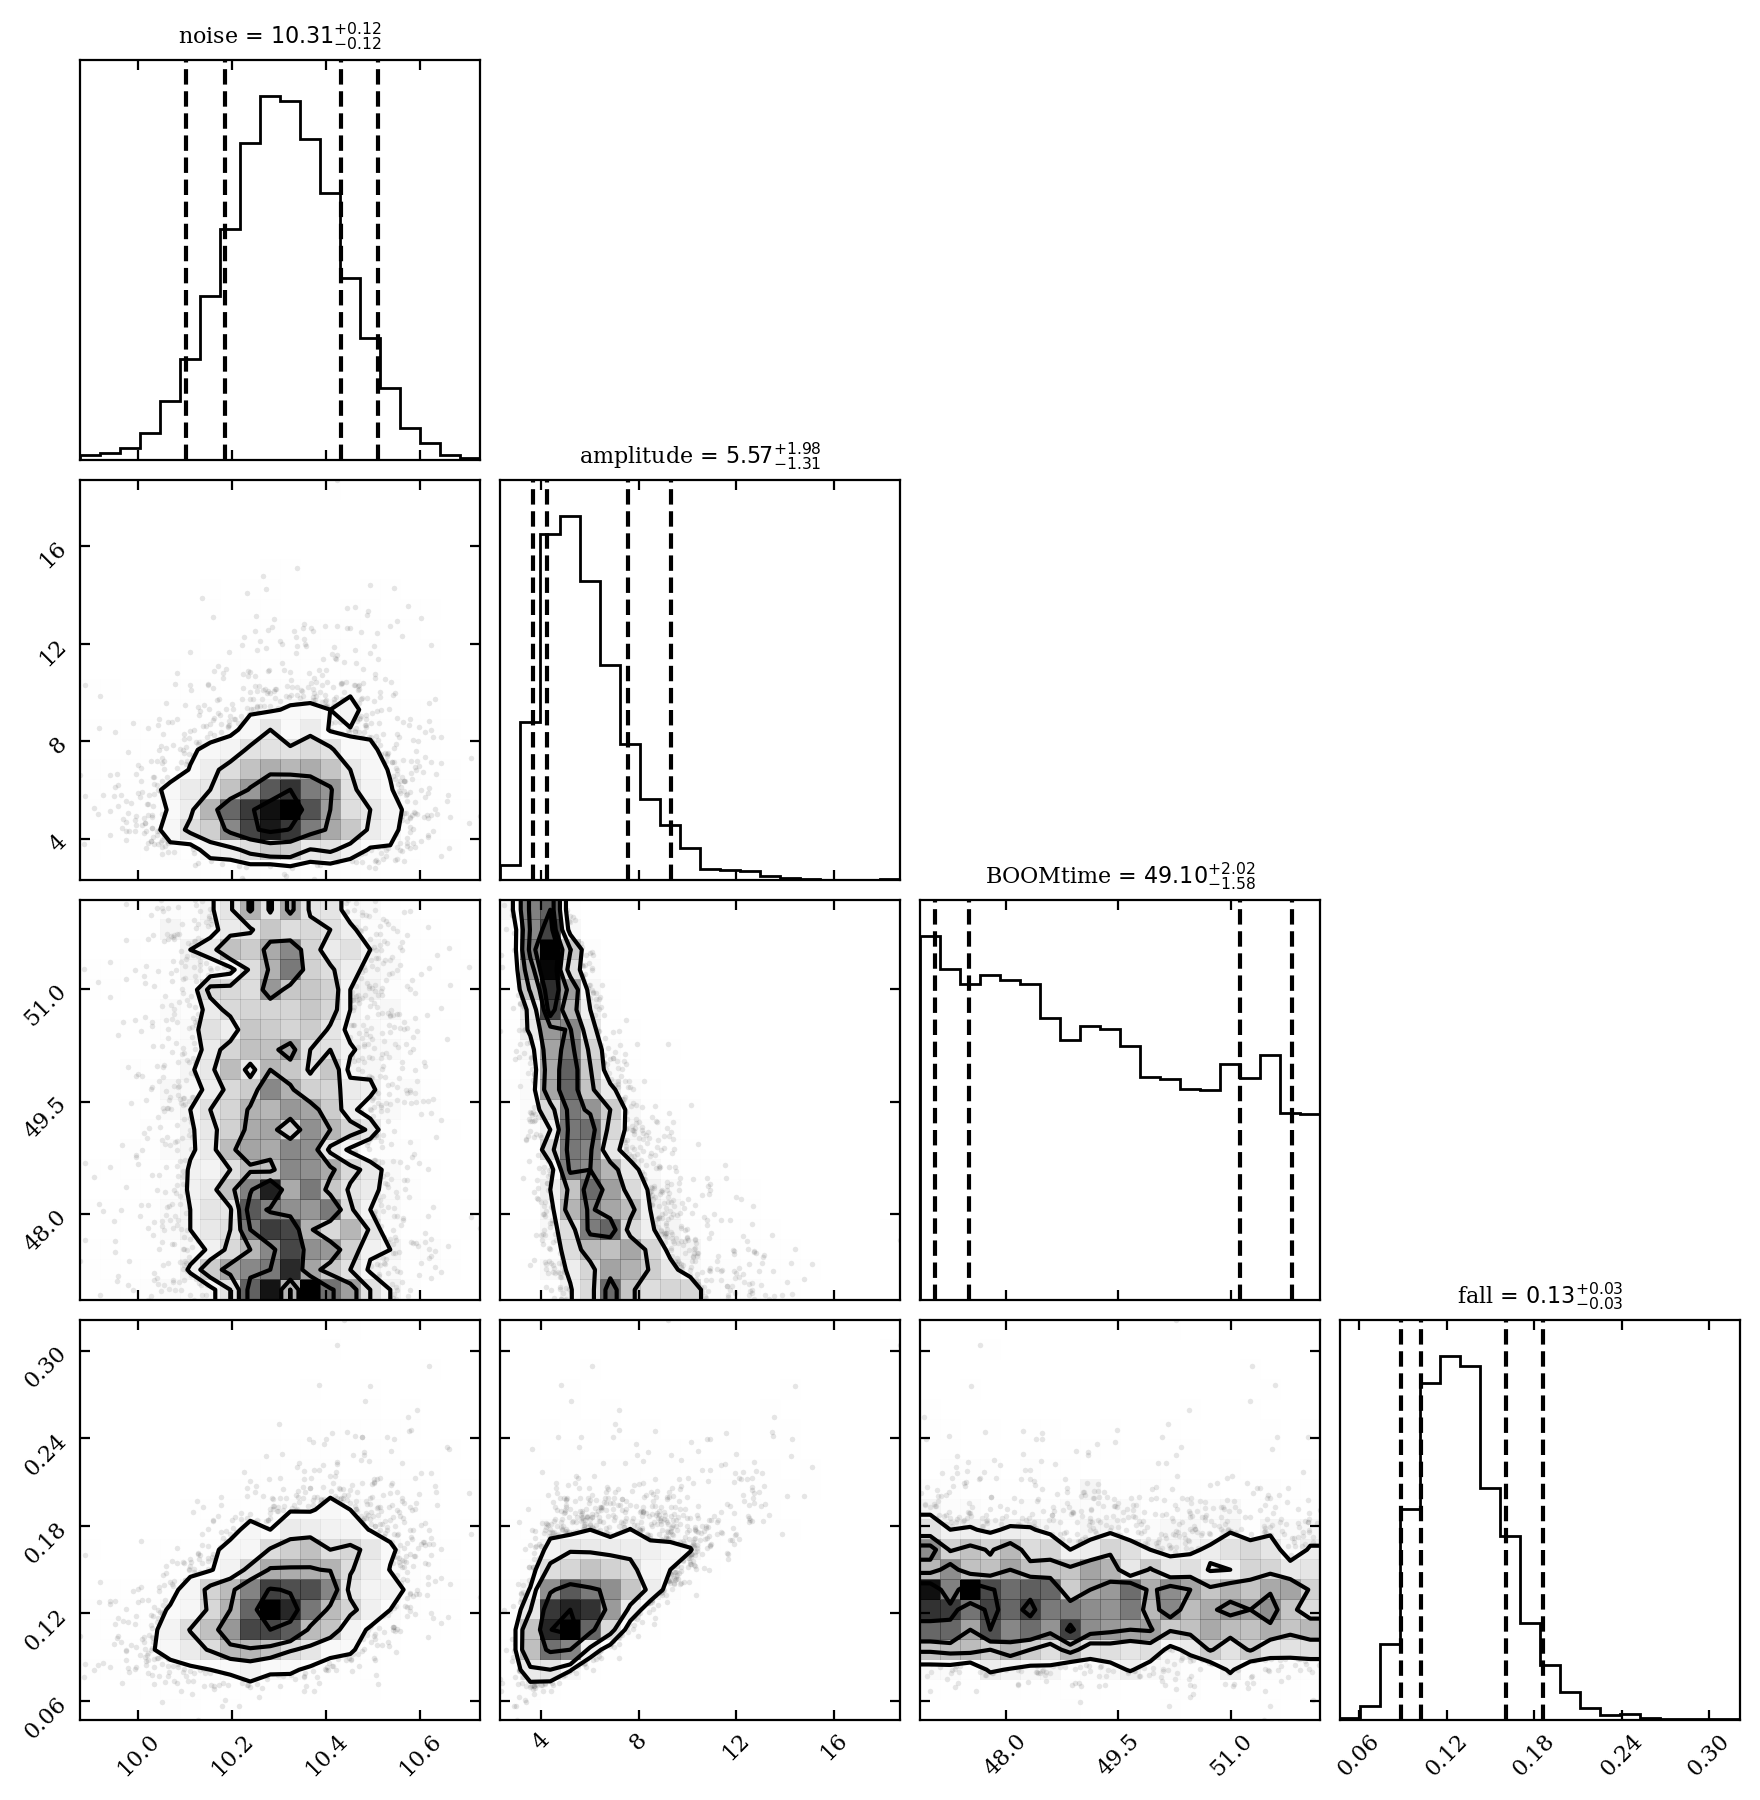

In [574]:
corner.corner(comb, quantiles = (0.05,0.16,0.84,0.95), show_titles = True, title_quantiles=(0.16,0.5,0.84), titles=['noise', 'amplitude', 'BOOMtime', 'fall'])

<ErrorbarContainer object of 3 artists>

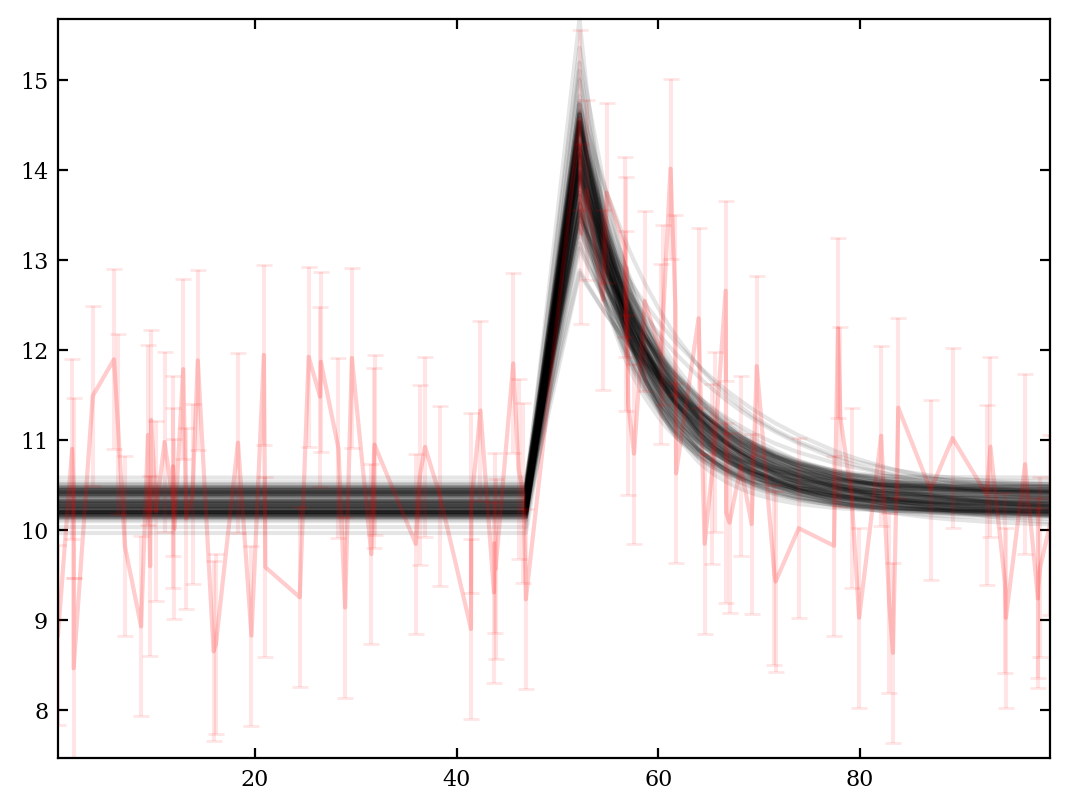

In [576]:
#6
Done = random.sample(range(len(a)),100) #Random selection of points

#For Loop to plot the burst model
for  e in Done: 
    Try = BOOM(comb[e],info)
    plt.plot(info[:,0],Try, color = "black", alpha = 0.1)

#Plotting the actual data to check fits
plt.plot(info[:,0],info[:,1], color = "red", alpha = 0.1)
plt.errorbar(info[:,0],info[:,1], yerr=info[:,2], color = "red", alpha = 0.1)

In [578]:
#7
#Parameter names for later
param_names = ['noise', 'amplitude', 'BOOMtime', 'logfall']

#Prior function for ultranest
def my_prior_transform(hypercube):
    params = hypercube.copy()

    # transform location parameter: uniform prior
    lo = 0
    hi = 50
    params[0] = hypercube[0] * (hi - lo) + lo

    lo = 0
    hi = 50
    params[1] = hypercube[1] * (hi - lo) + lo

    lo = 0
    hi = 100
    params[2] = hypercube[2] * (hi - lo) + lo

    # Exponential uniform prior 
    lo = -5
    hi = 5
    params[3] = e**(hypercube[3] * (hi - lo) + lo)

    return params

#Likelihood function which uses chi square
def my_likelihood(params):
    noise, amplitude, BOOMtime, fall = params
    # compute intensity at every x position according to the model
    y_model = []
    for x in info[:,0]:
        if x > BOOMtime:
            y_model.append(noise + amplitude * np.exp(-fall*((x - BOOMtime))))
        else:
            y_model.append(noise)
    # compare model and data with gaussian likelihood:
    like = -0.5 * np.sum(((y_model - info[:,1])/1)**2)
    return like

In [579]:
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, 
                                          my_prior_transform)

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


In [581]:
result = sampler.run()
sampler.print_results()

[ultranest] Widening roots to 400 live points (have 400 already) ...


INFO:ultranest:Widening roots to 400 live points (have 400 already) ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


[ultranest] Explored until L=-5e+01  


INFO:ultranest:Explored until L=-5e+01  


[ultranest] Likelihood function evaluations: 170172


INFO:ultranest:Likelihood function evaluations: 170172
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -65.18 +- 0.1065


INFO:ultranest:  logZ = -65.18 +- 0.1065


[ultranest] Effective samples strategy satisfied (ESS = 1938.9, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1938.9, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)


[ultranest]   logZ error budget: single: 0.19 bs:0.11 tail:0.01 total:0.11 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.19 bs:0.11 tail:0.01 total:0.11 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -65.173 +- 0.239
  single instance: logZ = -65.173 +- 0.193
  bootstrapped   : logZ = -65.179 +- 0.238
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    noise               : 9.80  │ ▁ ▁▁▁▁▁▁▁▁▂▃▄▄▄▆▇▇▇▇▇▇▅▄▄▃▃▂▁▁▁▁▁▁▁▁▁ │10.79     10.30 +- 0.12
    amplitude           : 1.4   │ ▁▁▂▅▇▇▇▆▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁      ▁   ▁ │22.9      5.7 +- 1.6
    BOOMtime            : 46.6  │ ▂▆▇▆▇▇▇▇▅▅▆▆▆▆▆▇▅▆▅▅▄▄▅▅▄▄▄▄▅▅▄▄▄▃▄▄▁ │52.4      49.2 +- 1.5
    logfall             : 0.030 │ ▁▁▁▁▁▁▂▃▅▆▆▇▇▇▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁ ▁▁ ▁▁ │0.297     0.126 +- 0.028



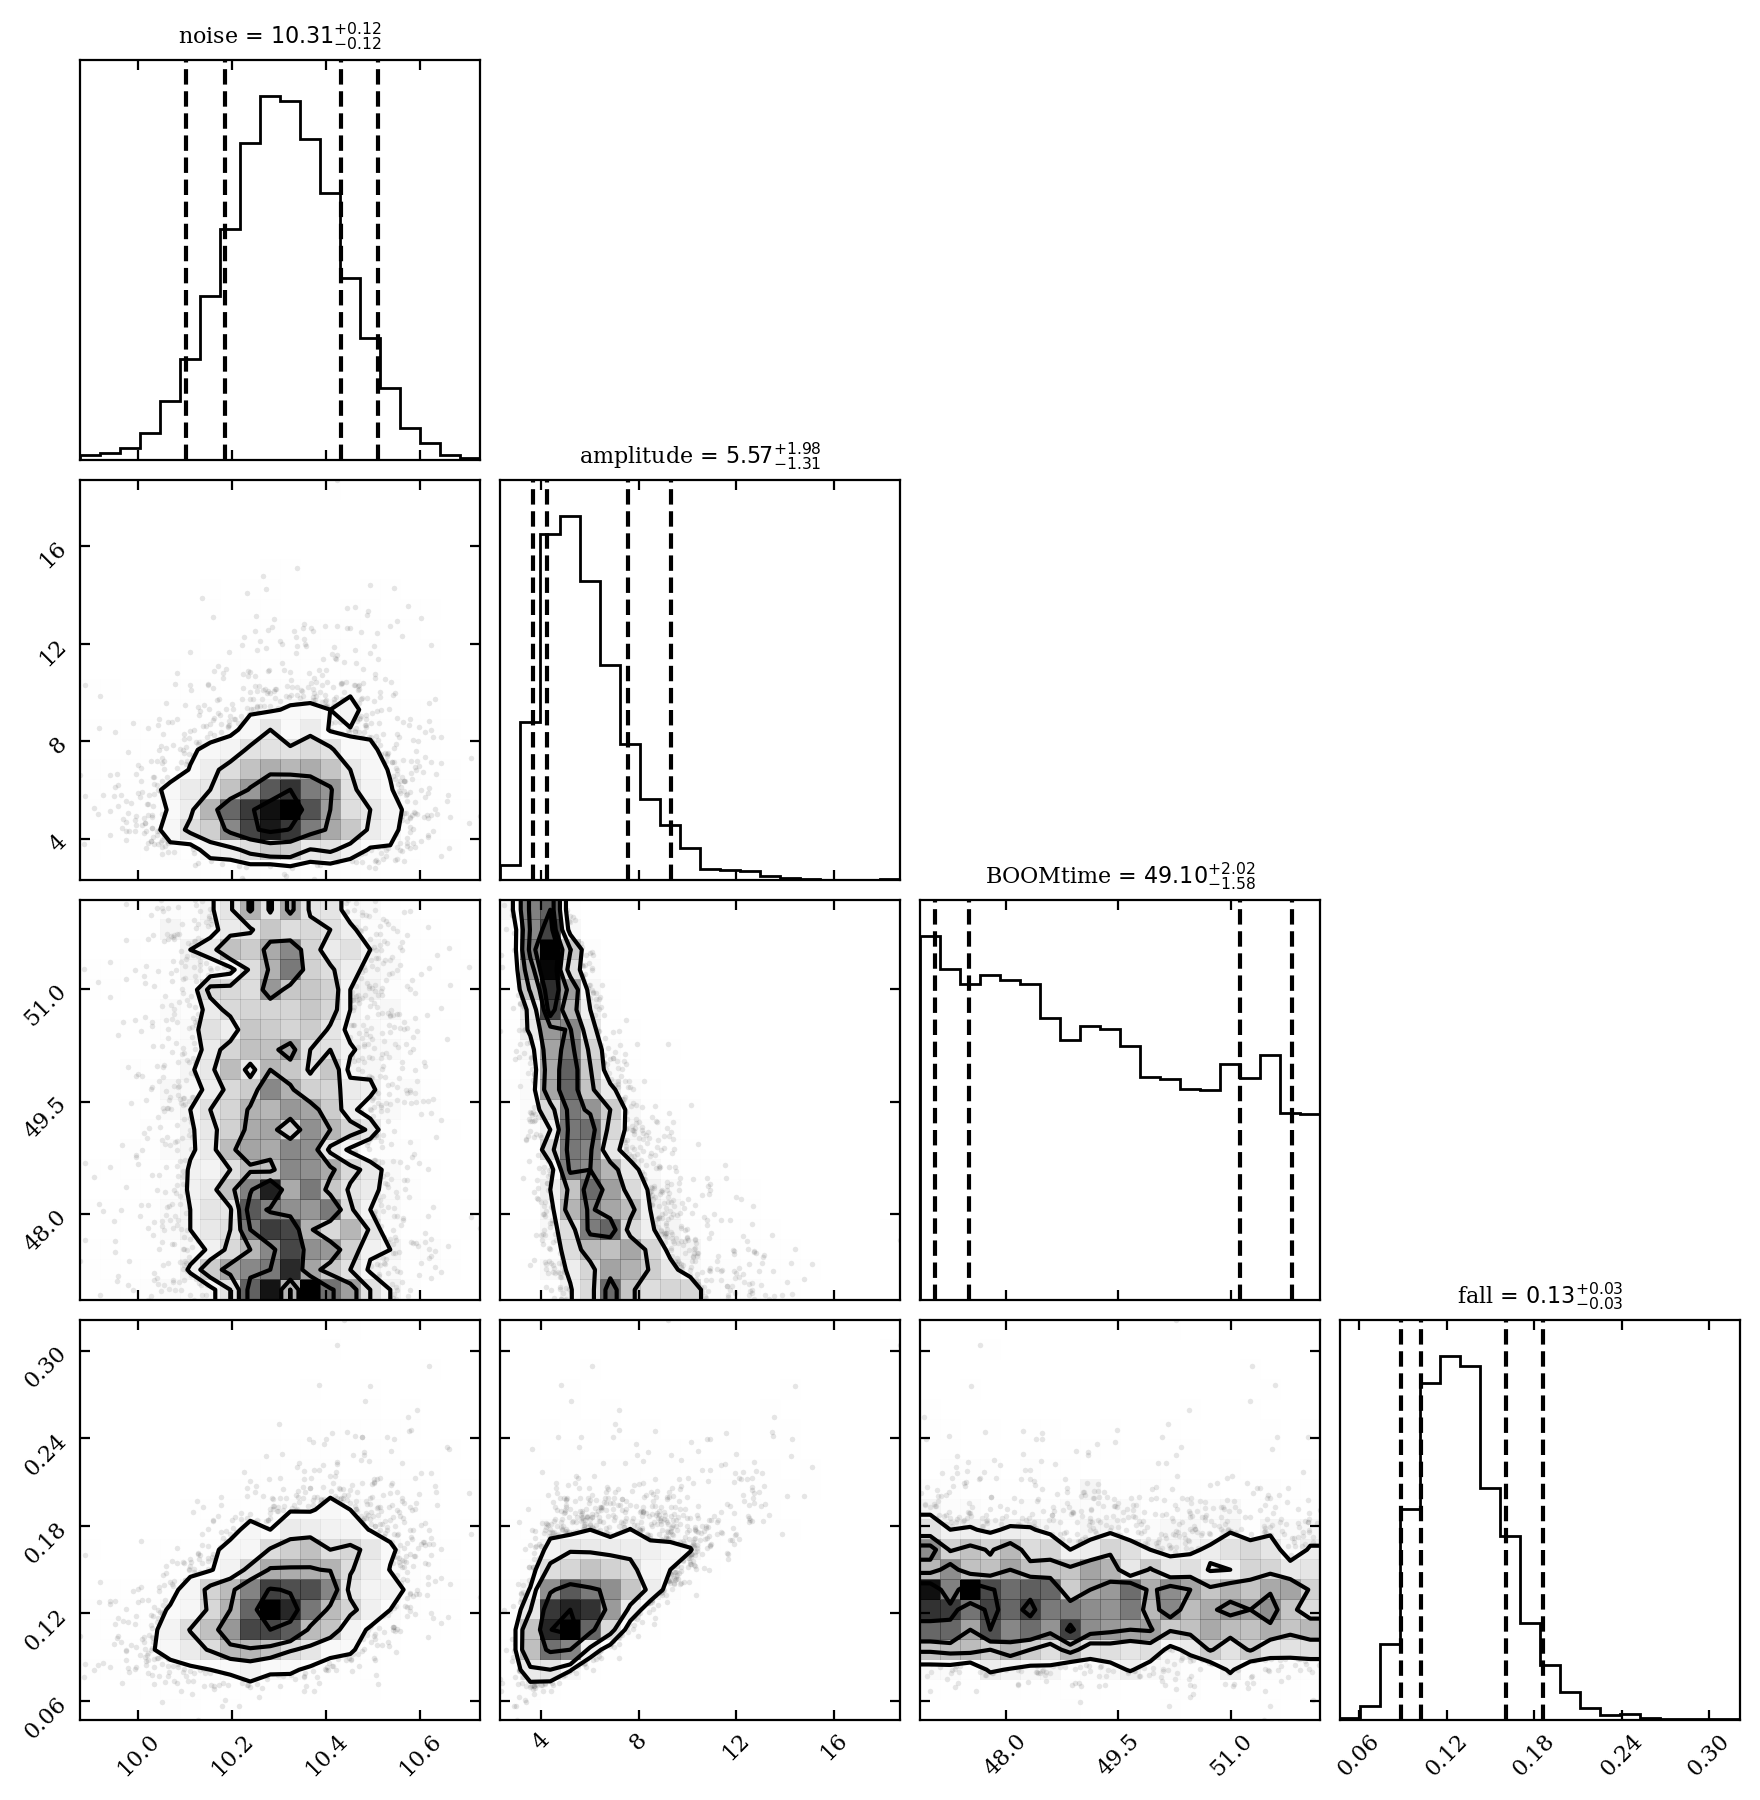

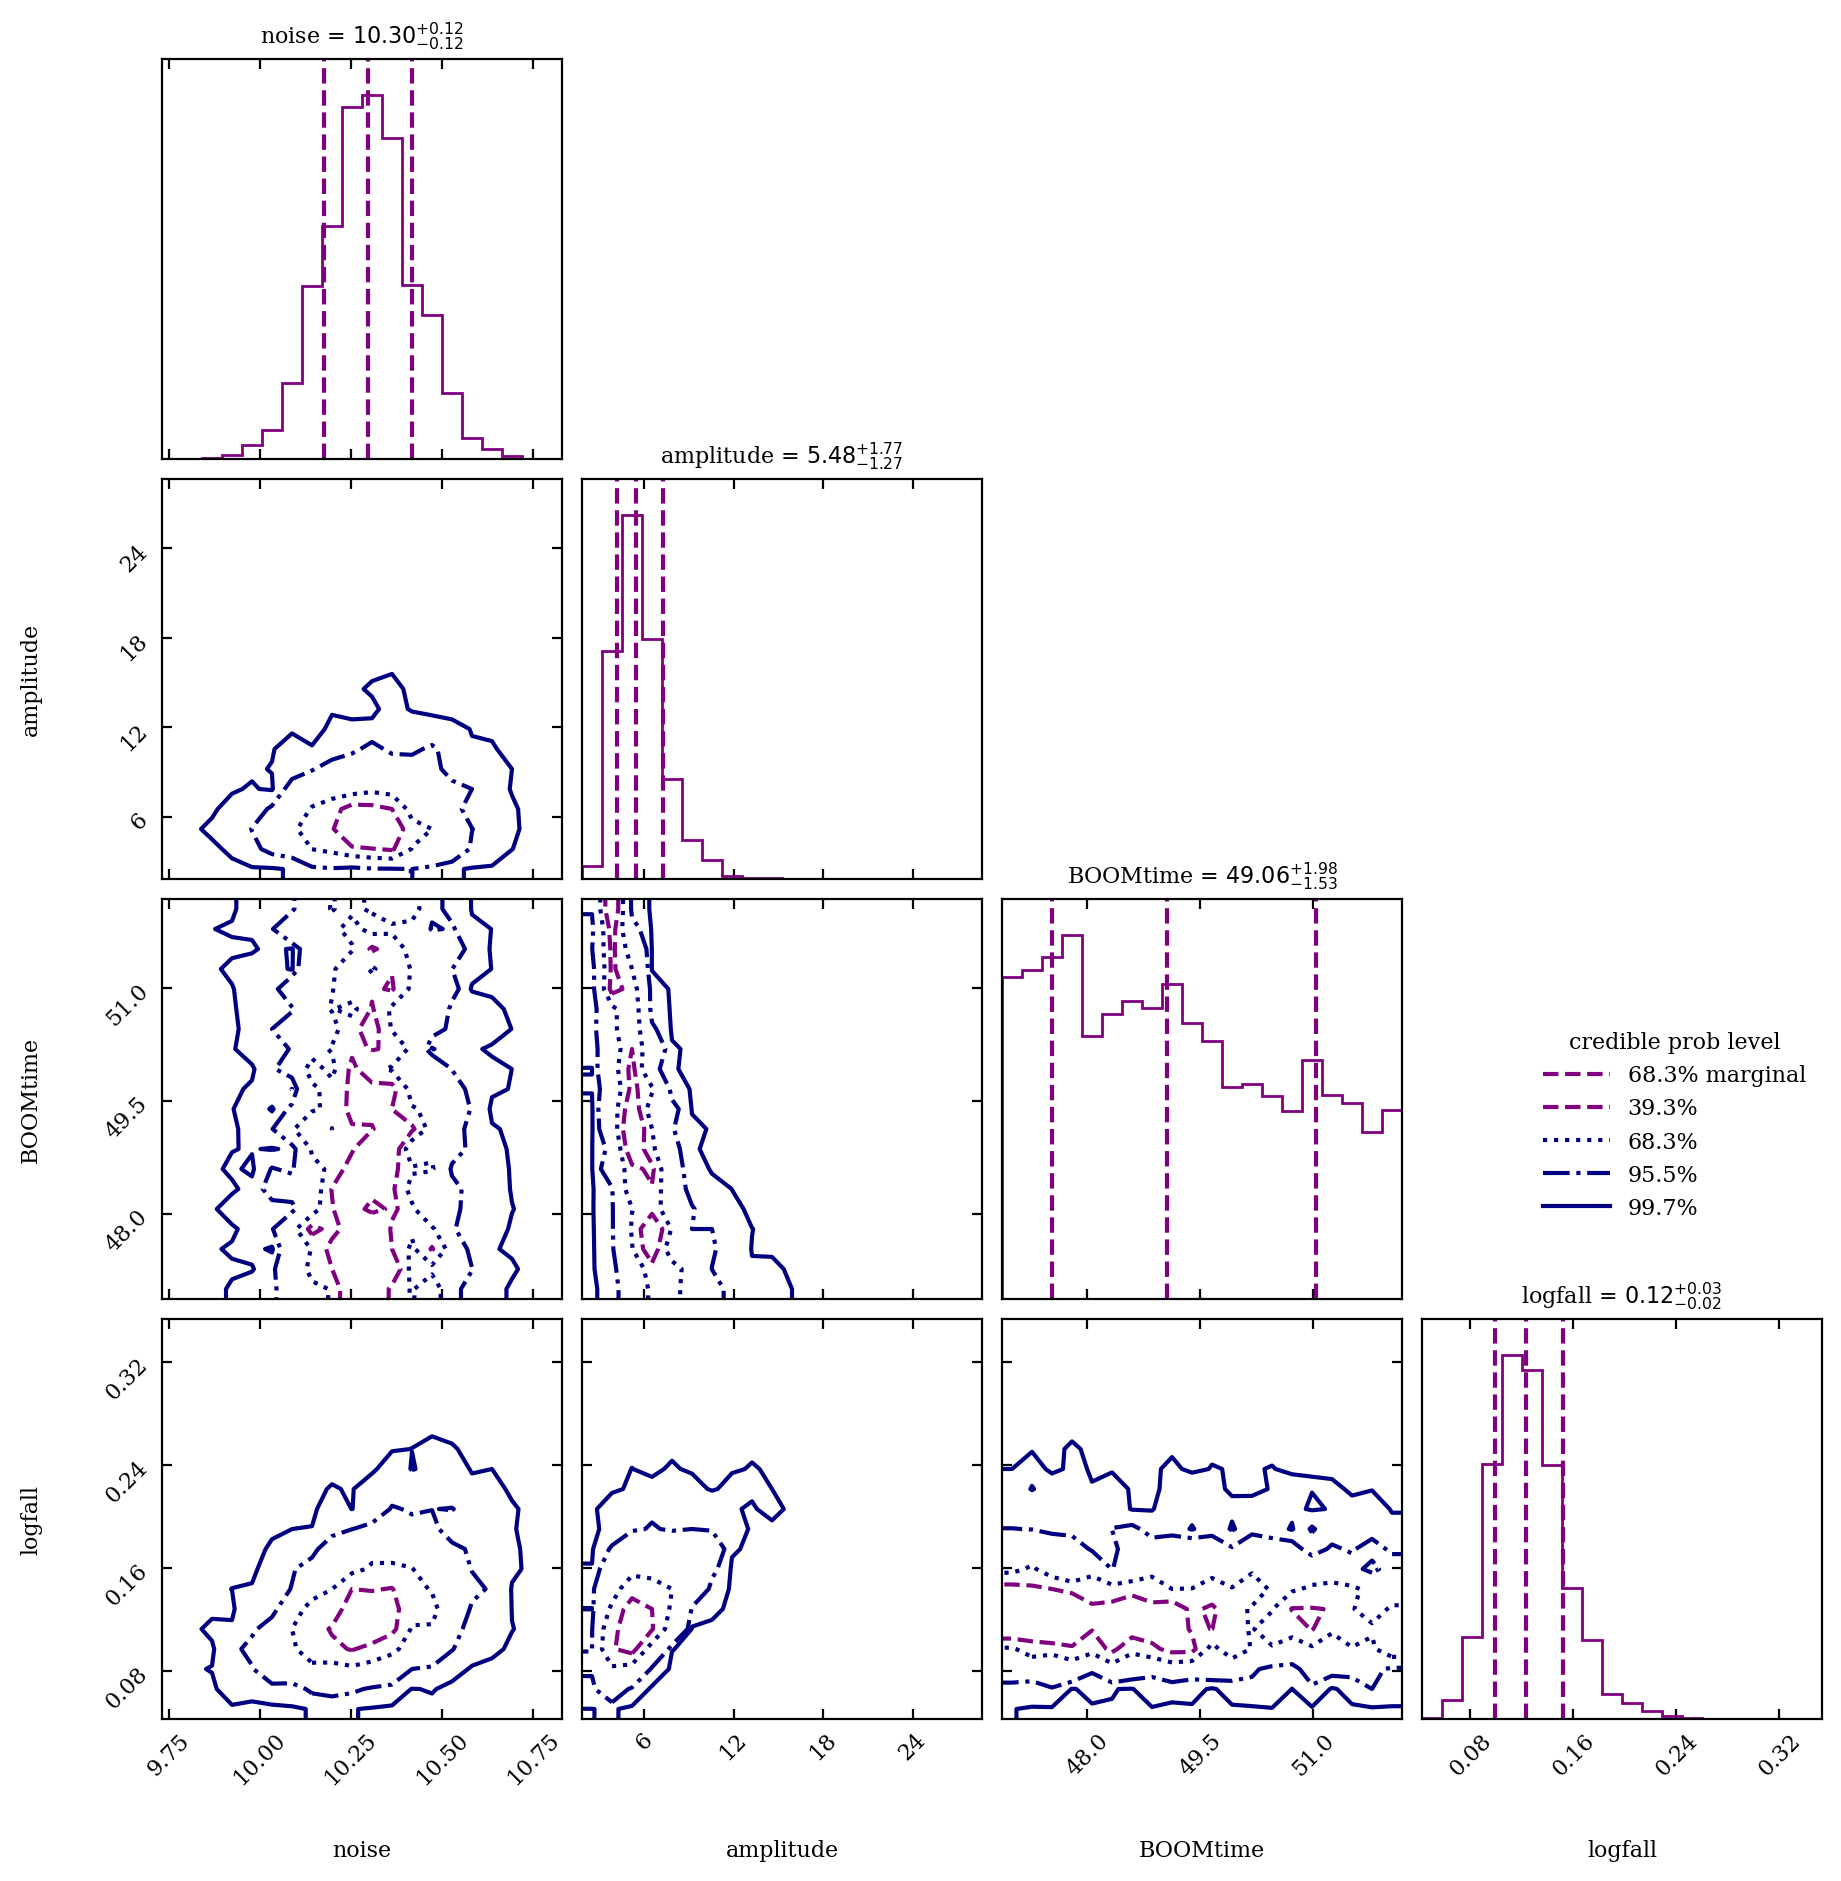

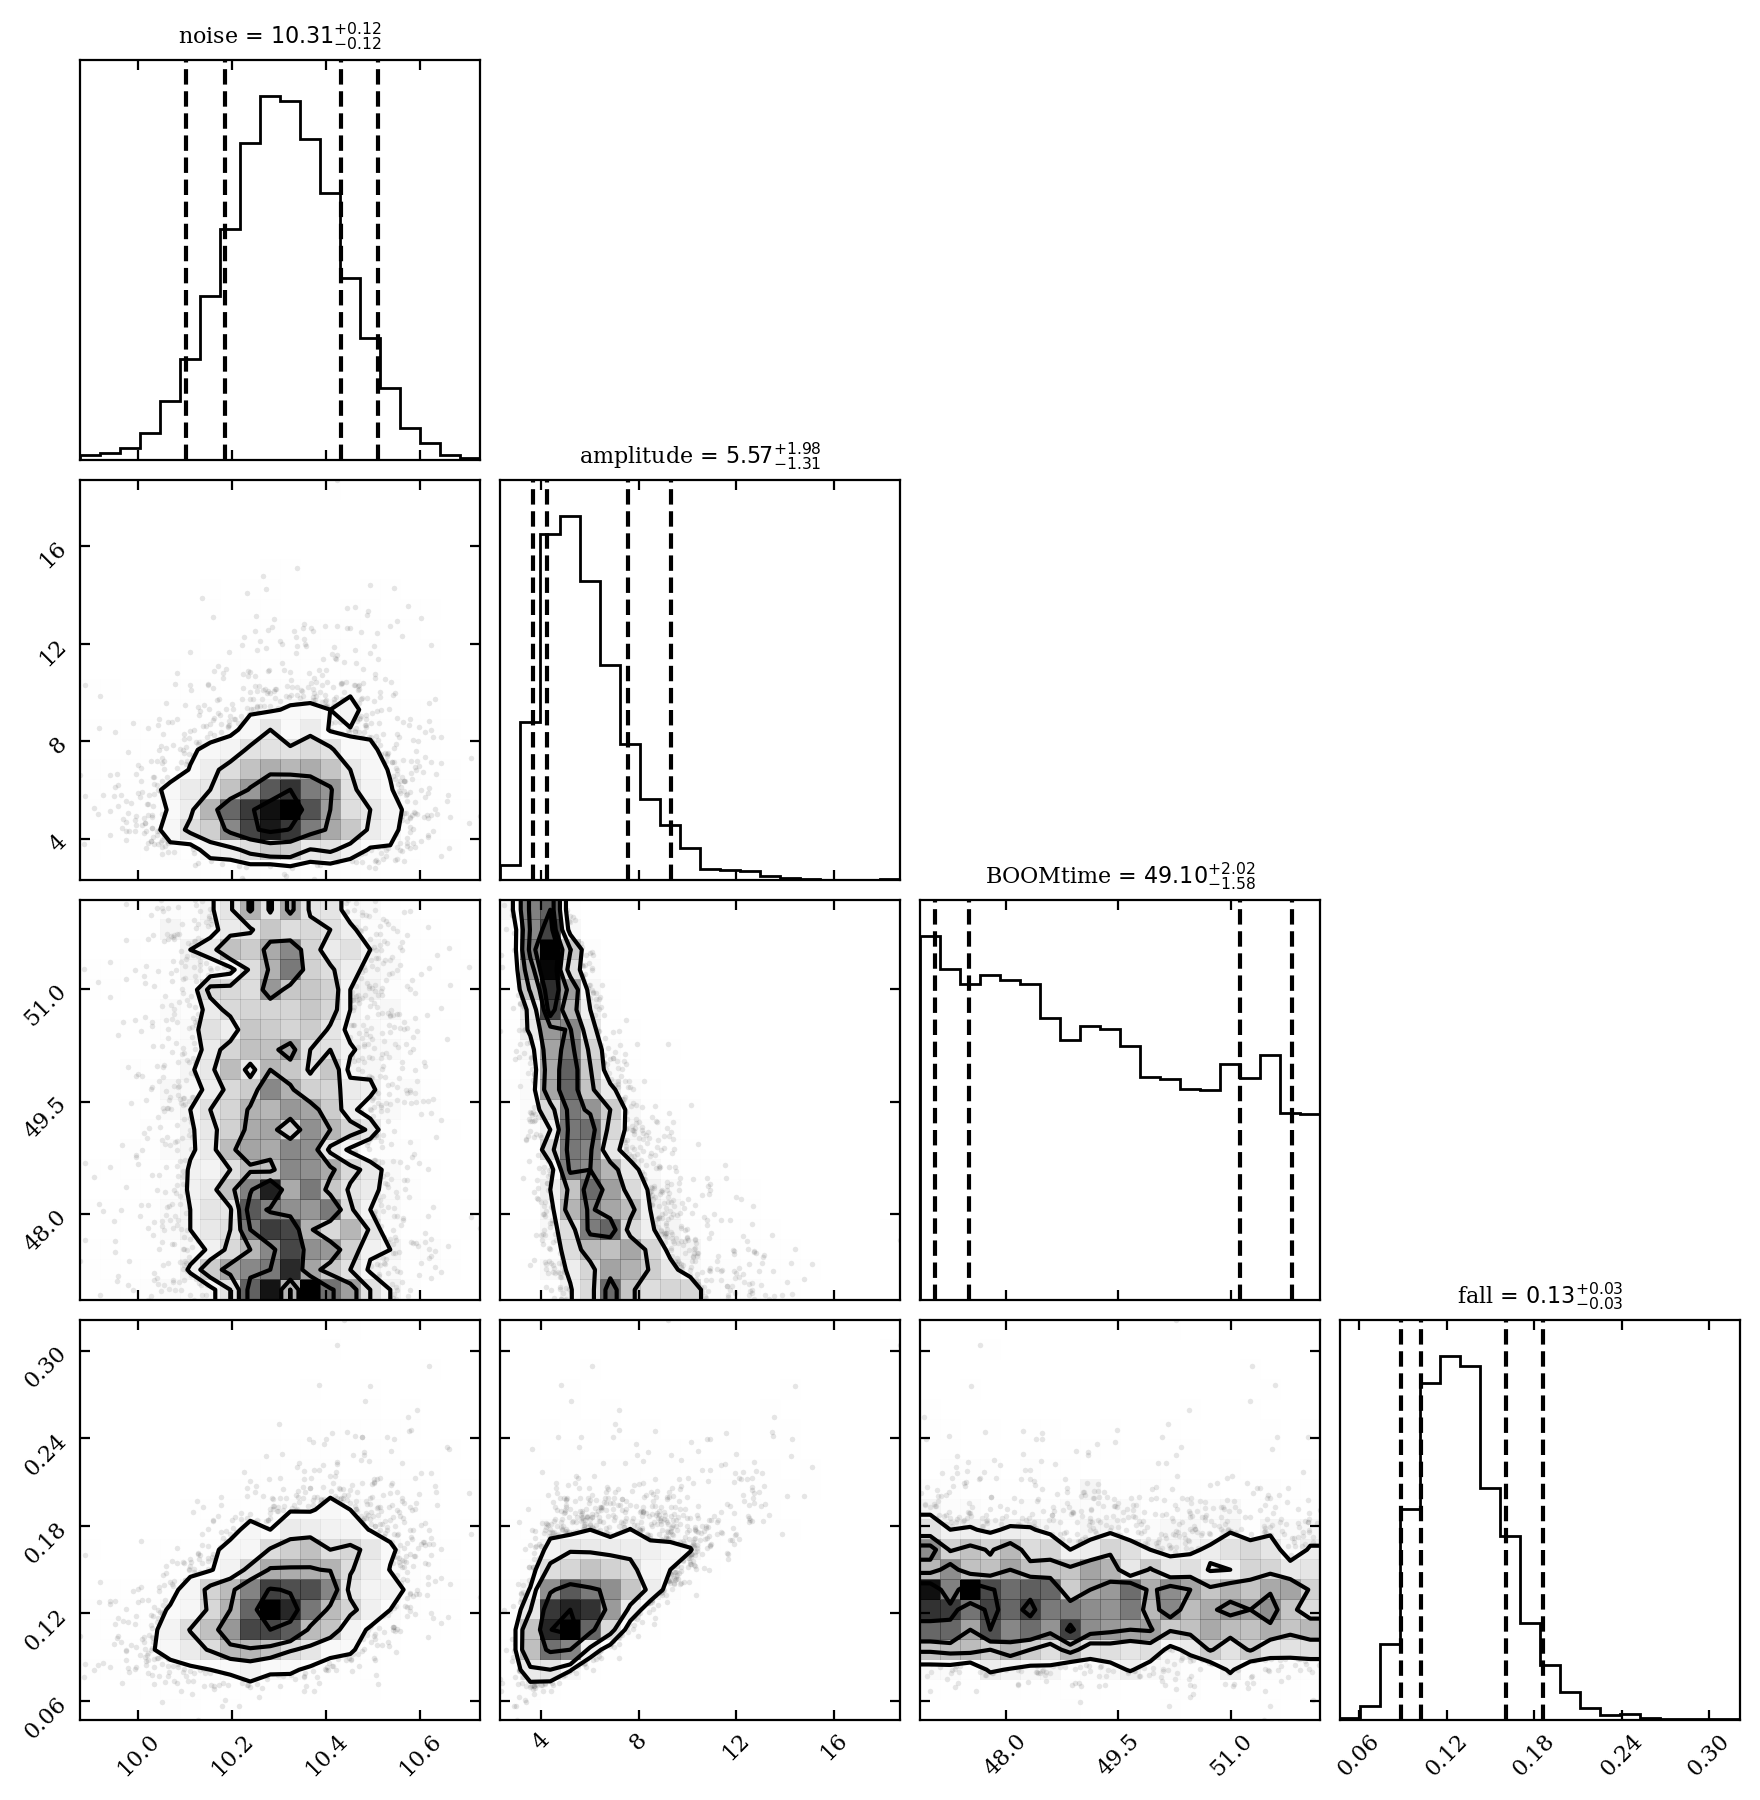

In [582]:
from ultranest.plot import cornerplot
cornerplot(result) #Comparing the corner plots from the Ultranest to MCMC
corner.corner(comb, quantiles = (0.05,0.16,0.84,0.95), show_titles = True, title_quantiles=(0.16,0.5,0.84), titles=['noise', 'amplitude', 'BOOMtime', 'fall'])


Fairly good fit, so it should be good

In [583]:
BOOMEvi = result['logz'] #Recording for Bayes Factor later
param_Gaussnames = ['noise', 'amplitude', 'time', 'spread']

In [584]:
def my_prior_transformgauss(hypercube): #Similar process as to the BOOM model
    params = hypercube.copy()
    
    lo = 0
    hi = 50
    params[0] = hypercube[0] * (hi - lo) + lo

    lo = 0
    hi = 50
    params[1] = hypercube[1] * (hi - lo) + lo

    lo = 0
    hi = 100
    params[2] = hypercube[2] * (hi - lo) + lo

    lo = -2
    hi = 2
    params[3] = e**(hypercube[3] * (hi - lo) + lo)

    return params

In [585]:
def my_likelihoodgauss(params): #Same process as BOOM
    noise, amplitude, time, spread = params
    # compute intensity at every x position according to the model
    y_model = []
    for x in info[:,0]:
            y_model.append(noise + amplitude * np.exp(-0.5*((x - time)/(spread))**2))
    # compare model and data with gaussian likelihood:
    like = -0.5 * np.sum(((y_model - info[:,1])/1)**2)
    return like

In [586]:
sampler = ultranest.ReactiveNestedSampler(param_Gaussnames, my_likelihoodgauss, 
                                          my_prior_transformgauss)

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


In [587]:
!pip3 install ipywidgets

In [589]:
result1 = sampler.run()
sampler.print_results()

[ultranest] Widening roots to 400 live points (have 400 already) ...


INFO:ultranest:Widening roots to 400 live points (have 400 already) ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


[ultranest] Explored until L=-5e+01  


INFO:ultranest:Explored until L=-5e+01  


[ultranest] Likelihood function evaluations: 496717


INFO:ultranest:Likelihood function evaluations: 496717
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -69.5 +- 0.1742


INFO:ultranest:  logZ = -69.5 +- 0.1742


[ultranest] Effective samples strategy satisfied (ESS = 2243.4, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 2243.4, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
DEBUG:ultranest:  conservative estimate says at least 191 live points are needed to reach dlogz goal
DEBUG:ultranest:  number of live points vary between 399 and 399, most (7060/7061 iterations) have 398
DEBUG:ultranest:  at least 398 live points are needed to reach dlogz goal


[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.13 to 0.56, need <0.5)


INFO:ultranest:Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.13 to 0.56, need <0.5)


[ultranest]   logZ error budget: single: 0.19 bs:0.17 tail:0.01 total:0.17 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.19 bs:0.17 tail:0.01 total:0.17 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -69.475 +- 0.402
  single instance: logZ = -69.475 +- 0.193
  bootstrapped   : logZ = -69.502 +- 0.402
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    noise               : 9.72  │ ▁   ▁▁▁▁▁▁▁▁▂▂▄▄▆▆▇▇▇▇▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁ │10.85     10.32 +- 0.12
    amplitude           : 1.25  │ ▁▁▁▁▁▁▁▁▂▂▃▄▅▅▆▇▇▇▆▅▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁ ▁ │4.50      2.76 +- 0.39
    time                : 51.31 │ ▁  ▁▁▁▁▁▁▂▂▄▄▅▆▇▇▇▇▇▅▅▅▃▃▂▁▁▁▁▁▁▁▁▁ ▁ │59.78     55.38 +- 0.99
    spread              : 1.59  │ ▁ ▁▁▁▁▁▂▃▄▅▆▇▇▇▇▅▄▃▃▂▁▁▁▁▁▁▁▁ ▁     ▁ │11.09     5.24 +- 0.88



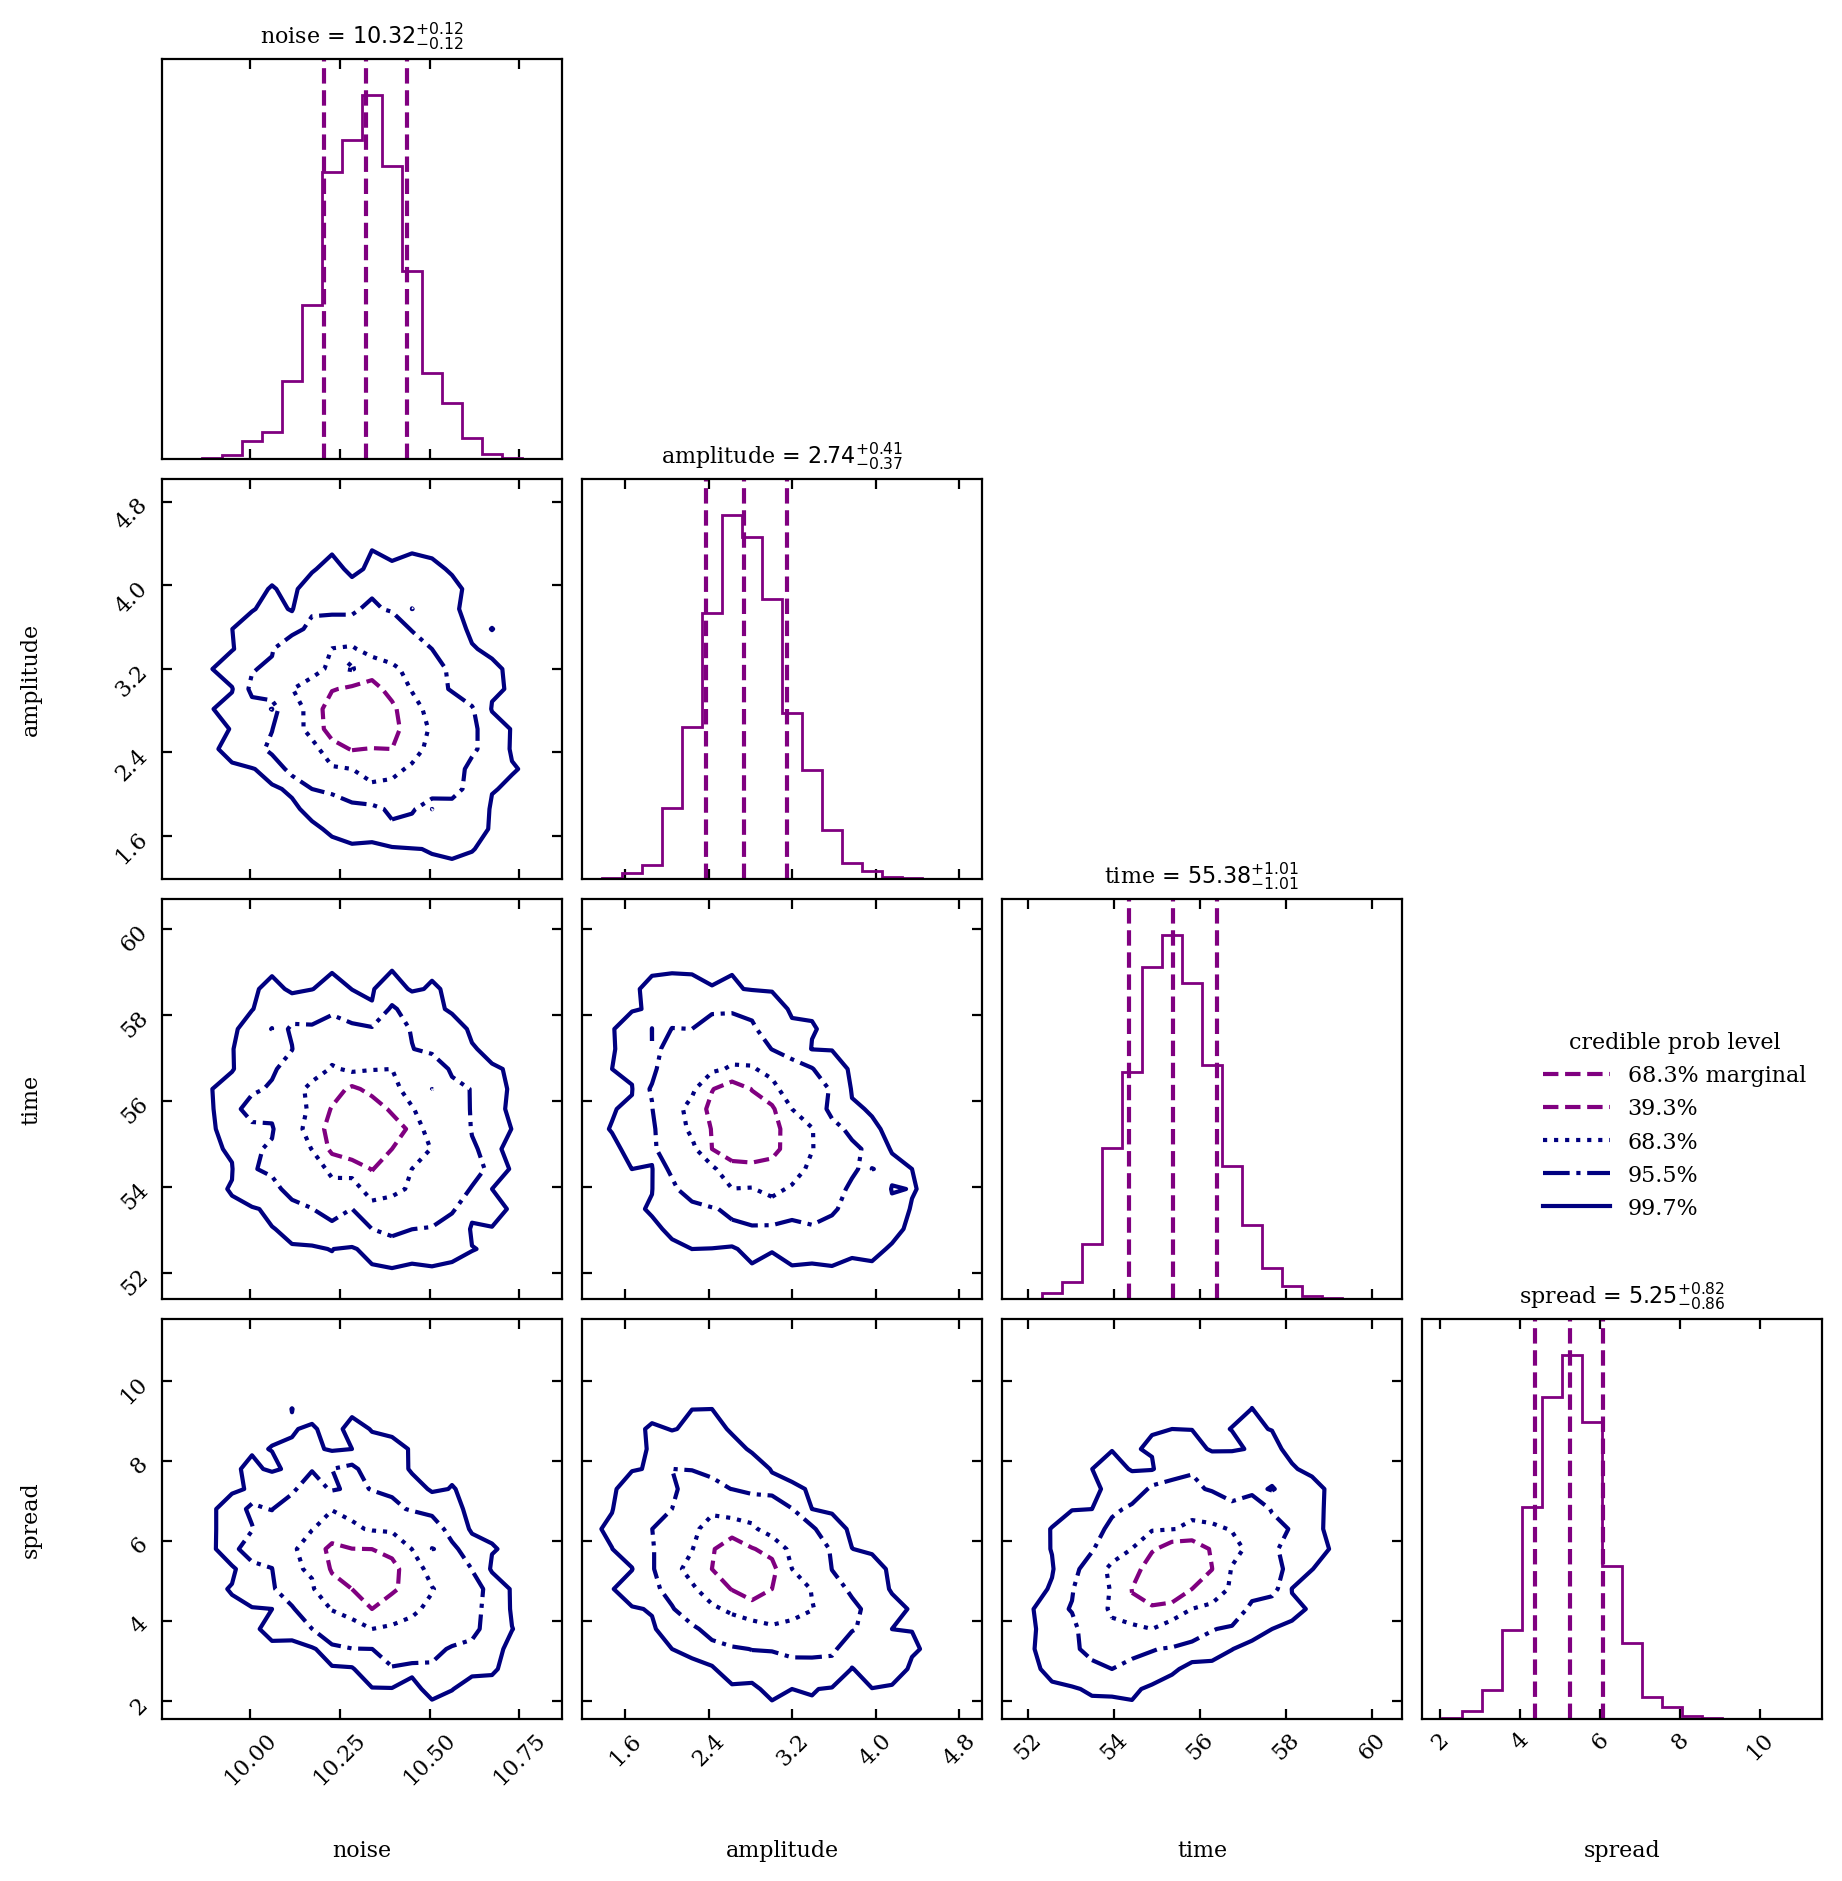

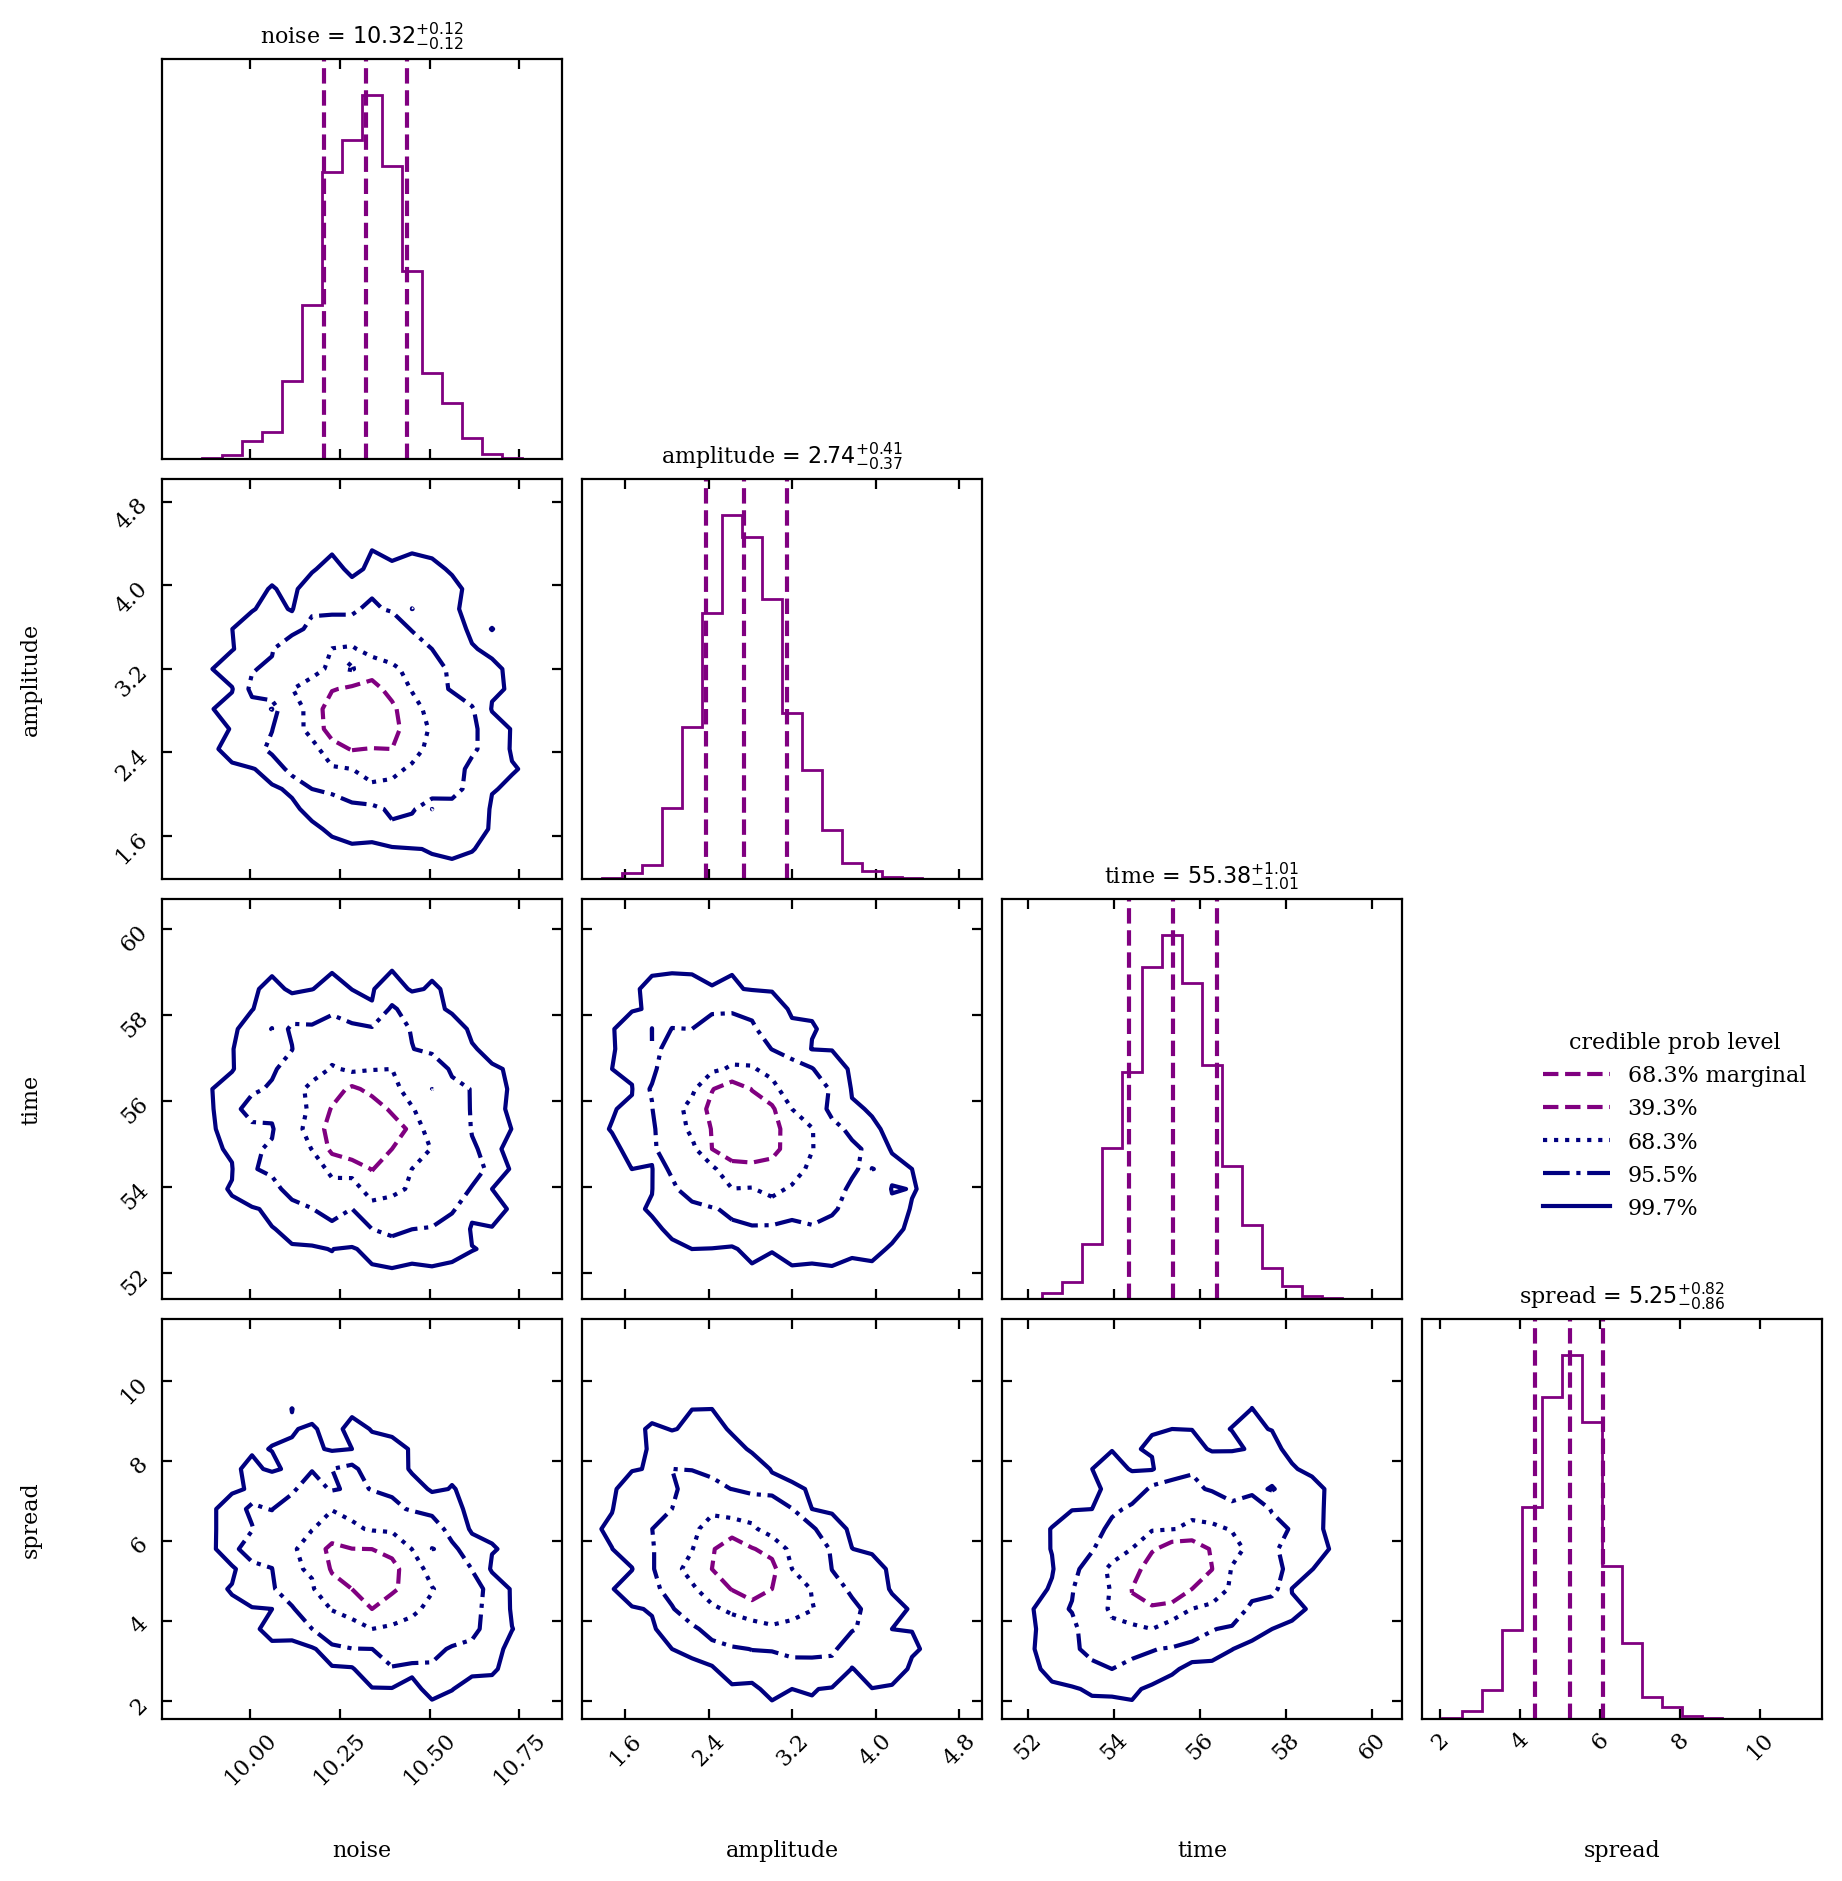

In [590]:
cornerplot(result1) #Wanted to look at corner plot

In [591]:
GaussEvi= result1['logz'] #Recording for Bayes Factor

In [592]:
LogBayes = BOOMEvi-GaussEvi
print(np.exp(LogBayes))

73.86585703714341


Over 4 runs the bottom values were what I got

In [594]:
np.sum([83.56717595885526, 73.86585703714341, 135, 95])/4

96.85825824899968

The Bayes factor consistently remains above 30, so there is a substantial improvement with the burst model comparied to gaussian, and is likely that the burst is a definitively better fit as well